# Visualize ambiguity

In [105]:
import pandas as pd
from pathlib import Path
# paths = Path('wiki/iawiki-latest/iawiki-latest-paragraph-links').glob('*')
paths = Path('wiki/simplewiki-20211120/simplewiki-20211120-paragraph-links').glob('0*')
df = pd.concat([
    pd.read_csv(p, sep='\t', on_bad_lines='skip', names=['page', 'ents', 'text']) 
    for p in paths if p.stat().st_size
], ignore_index=True)
df.shape

(98545, 3)

In [107]:
import json
links = df['ents'].apply(json.loads).apply(dict.items).explode()
links = pd.DataFrame(links.tolist(), index=links.index, columns=['name', 'qid'])
links.groupby('name')['qid'].apply(lambda x: len(set(x))).sort_values().tail(20)

name
German                      11
1st                         12
British                     12
state                       12
City                        13
Western                     14
Chinese                     14
Roman                       14
1                           15
2                           15
Central                     16
English                     17
National Assembly           18
House of Representatives    19
Province                    20
Parliament                  28
Senate                      33
County                      36
Prime Minister              79
President                   99
Name: qid, dtype: int64

In [159]:
name = 'English'
sub  = links.loc[links['name'] == name].groupby('qid').filter(lambda x: len(x) > 5)
texts = df.loc[sub.index, 'text']

import requests
def get_description(*ids):
    params = {
        'action': 'wbgetentities',
        'ids': '|'.join(['Q%s'%i for i in ids]),
        'languages': 'en',
        'props': 'descriptions',
        'format': 'json',
    }
    resp = requests.get('https://www.wikidata.org/w/api.php', params=params).json()
    return {k:v.get('descriptions', {}).get('en', {}).get('value', None)
            for k,v in resp.get('entities', {}).items()}

qid_desc = {int(k[1:]):('%9s '%k) + v[:40] for k,v in get_description(*sub['qid'].unique()).items()}

print(sub['qid'].replace(qid_desc).value_counts())

qid
    Q1860 West Germanic language                      727
      Q21 country in north-west Europe, part of th    711
   Q42406 ethnic group native to England              342
     Q182 Wikimedia disambiguation page                48
     Q145 country in north-west Europe                 15
  Q179876 historic kingdom on the British Isles (9     14
    Q7976 set of dialects of the English language       9
 Q2363292 dialect within the English language           8
Name: count, dtype: int64


(1874, 16423)
Explained variance of the SVD step: 29.9%


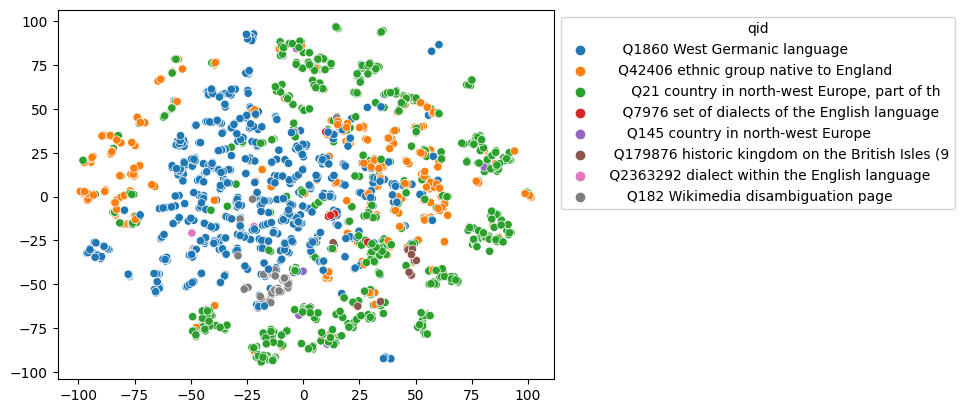

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=3,
    ngram_range=(1,3),
)
X_tfidf = vectorizer.fit_transform(texts)
print(X_tfidf.shape)

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X_lsa)

import seaborn as sns
import numpy as np

ax = sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=sub['qid'].replace(qid_desc))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [161]:
qid_means = pd.DataFrame(X_lsa, index=sub.index).join(sub['qid']).groupby('qid').mean()
original_space_centroids = lsa[0].inverse_transform(qid_means)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i,qid in enumerate(qid_means.index):
    print(f"{qid_desc[qid]:51s}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

      Q21 country in north-west Europe, part of th : american footballer actor politician category actress singer player german french 
     Q145 country in north-west Europe             : american singer actor actress politician footballer german french player writer 
     Q182 Wikimedia disambiguation page            : simple wikipedia to be simple english you utc that english wikipedia is 
    Q1860 West Germanic language                   : is to it are language as of the was in the languages 
    Q7976 set of dialects of the English language  : she is to states united states united her state the united states in the 
   Q42406 ethnic group native to England           : category he was category english born an an english is from to 
  Q179876 historic kingdom on the British Isles (9 : king january november may december october july march september de 
 Q2363292 dialect within the English language      : welsh have word is some as like that not in english 
